In [8]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas_datareader as web
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
import pickle
import seaborn as sns
import datetime as dt
import yfinance as yf
import talib
from tqdm.notebook import tqdm
%matplotlib inline


class LinearModel:
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)
        self.vW = 0
        self.vb = 0
        self.losses = []
        
    def predict(self, s):
        return s.dot(self.W) + self.b
    
    def sgd(self, s, Y, learning_rate=0.001, momentum=0.9):
        num_values = np.prod(Y.shape)
        Y_hat = self.predict(s)
        Y_hat = self.predict(s)  # shape (1, 8)
        gW = 2 * s.T.dot(Y_hat - Y) / num_values  # vector shape (7, 8)
        gb = 2 * (Y_hat - Y).sum(axis=0) / num_values  # scalar

        self.vW = momentum * self.vW - learning_rate * gW  # vector shape (7, 8)
        self.vb = momentum * self.vb - learning_rate * gb  # scalar

        self.W += self.vW  # vector shape (7, 8)
        self.b += self.vb  # scalar

        mse = np.mean((Y_hat - Y) ** 2)
        self.losses.append(mse)
        
        
    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)


    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']
        
        
class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action


    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_weights(name)


    def save(self, name):
        self.model.save_weights(name)
        
        
        
        
class StockEnv:
    def __init__(self, data, capital, trade_fee_bid_percent = 0.01, trade_fee_ask_percent = 0.005):
        self.trade_fee_bid_percent = trade_fee_bid_percent/100  # percent
        self.trade_fee_ask_percent = trade_fee_ask_percent/100  # percent
        
        self.stock_price_history = data['Adj Close']
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.current_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 5 #[stock price, stock_owned, cash__in_hand, rsi, mom]
        self.save_position = []
        self.save_port_val = [] 
        self.save_cash = []
        self.stock_value = []
        self.action_space = [0,1]
        self.sell_buy = []
        self.save_stock_price = []
        self.rsi = data['rsi']
        self.mom = data['mom']
        self.reset()
        
        
    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi[self.current_step]
        vector[4] = self.mom[self.current_step]
        return vector
    
    
    def reset(self):
        self.current_step = 0
        self.stock_owned = 0
        self.stock_price = self.stock_price_history[self.current_step]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital] 
        self.save_cash = [self.capital]
        self.stock_value = [0]
        self.sell_buy = ['hold']
        self.save_stock_price = [self.stock_price]
        return self.state_vector()
    

    
    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand
    
    
    def cal_position(self):
        high = self.stock_price_history.max()
        mid_price =  high/ 2
        max_pos = self.capital / mid_price
        slope = max_pos/-high
        c = -slope * high
        
        return slope * self.stock_price + c, high, max_pos
        
      
    def trade(self, action):
        '''
        action 0 = hold
        action 1 = take action
        '''
        assert action in self.action_space
        
        if action == 1:
            position_sh, high, max_pos = self.cal_position()
            diff = position_sh - self.stock_owned
            if diff < 0:
                #sell
                self.stock_owned = position_sh
                self.cash_in_hand += (abs(diff) * self.stock_price * (1 - self.trade_fee_ask_percent))
                self.sell_buy.append('sell')
                
                
            elif diff > 0:
                #buy
                self.stock_owned = position_sh
                self.cash_in_hand -= (abs(diff) * self.stock_price * (1 + self.trade_fee_bid_percent))
                self.sell_buy.append('buy')
                
            else:
                self.sell_buy.append('hold')
                
        else:
            self.sell_buy.append('hold')
            
        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)
        
          
        
                
    def step(self, action):
        assert action in self.action_space
        
        prev_val = self.port_val()
        self.current_step += 1
        self.stock_price = self.stock_price_history[self.current_step]
        
        self.trade(action)
        current_val = self.port_val()
        reward = current_val - prev_val
        done = self.current_step == self.n_step - 1
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
#                 'current_val': self.port_val(),
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy':self.sell_buy
               }
        
        return self.state_vector(), reward, done, info
    
    
def get_scaler(env):
    states = []
    for i in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler



        
        
def play_one_episode(agent, env, is_train):
    state = env.reset()
    state = scaler.transform([state])
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        
        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)
        
        state = next_state
    
    return info

In [9]:
stock_name = 'ibm'.upper()
stock_data = pd.read_csv(f'../train_test_data/{stock_name}.csv', index_col=['Date'], parse_dates=True)

train_data = stock_data.loc[:'2018-01-01']
test_data = stock_data.loc['2018-01-01':]


num_episodes = 2000
batch_size = 32
capital = 1000
data = stock_data['Adj Close'].values
n_timesteps = data.shape[0]


env = StockEnv(train_data, capital)
state_size = env.state_dim
action_size = 2
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

  0%|          | 0/2000 [00:00<?, ?it/s]

episode: 1/2000, episode end value: 1022.90, duration: 0:00:00.194043
episode: 2/2000, episode end value: 984.52, duration: 0:00:00.196043
episode: 3/2000, episode end value: 1018.68, duration: 0:00:00.220049
episode: 4/2000, episode end value: 1029.99, duration: 0:00:00.182042
episode: 5/2000, episode end value: 975.15, duration: 0:00:00.192043
episode: 6/2000, episode end value: 1002.40, duration: 0:00:00.198552
episode: 7/2000, episode end value: 991.33, duration: 0:00:00.221159
episode: 8/2000, episode end value: 1010.72, duration: 0:00:00.207045
episode: 9/2000, episode end value: 988.54, duration: 0:00:00.218810
episode: 10/2000, episode end value: 1024.22, duration: 0:00:00.203045
episode: 11/2000, episode end value: 984.40, duration: 0:00:00.203553
episode: 12/2000, episode end value: 1045.37, duration: 0:00:00.204046
episode: 13/2000, episode end value: 993.25, duration: 0:00:00.204045
episode: 14/2000, episode end value: 989.54, duration: 0:00:00.219048
episode: 15/2000, epis

episode: 118/2000, episode end value: 1007.44, duration: 0:00:00.205045
episode: 119/2000, episode end value: 995.80, duration: 0:00:00.222052
episode: 120/2000, episode end value: 1051.02, duration: 0:00:00.219049
episode: 121/2000, episode end value: 997.25, duration: 0:00:00.209047
episode: 122/2000, episode end value: 1041.03, duration: 0:00:00.208046
episode: 123/2000, episode end value: 1019.20, duration: 0:00:00.209044
episode: 124/2000, episode end value: 1028.80, duration: 0:00:00.220052
episode: 125/2000, episode end value: 997.14, duration: 0:00:00.206043
episode: 126/2000, episode end value: 991.55, duration: 0:00:00.221048
episode: 127/2000, episode end value: 988.04, duration: 0:00:00.220064
episode: 128/2000, episode end value: 1050.93, duration: 0:00:00.203031
episode: 129/2000, episode end value: 990.37, duration: 0:00:00.217048
episode: 130/2000, episode end value: 998.34, duration: 0:00:00.207044
episode: 131/2000, episode end value: 1001.07, duration: 0:00:00.199043

episode: 233/2000, episode end value: 1000.04, duration: 0:00:00.236052
episode: 234/2000, episode end value: 1025.41, duration: 0:00:00.224051
episode: 235/2000, episode end value: 1011.03, duration: 0:00:00.202044
episode: 236/2000, episode end value: 993.96, duration: 0:00:00.206553
episode: 237/2000, episode end value: 986.29, duration: 0:00:00.214047
episode: 238/2000, episode end value: 996.99, duration: 0:00:00.211046
episode: 239/2000, episode end value: 996.61, duration: 0:00:00.226049
episode: 240/2000, episode end value: 1008.41, duration: 0:00:00.216049
episode: 241/2000, episode end value: 1001.75, duration: 0:00:00.225049
episode: 242/2000, episode end value: 1006.19, duration: 0:00:00.213042
episode: 243/2000, episode end value: 984.65, duration: 0:00:00.207549
episode: 244/2000, episode end value: 1002.00, duration: 0:00:00.215307
episode: 245/2000, episode end value: 999.28, duration: 0:00:00.213938
episode: 246/2000, episode end value: 1047.30, duration: 0:00:00.20590

episode: 348/2000, episode end value: 1030.25, duration: 0:00:00.210046
episode: 349/2000, episode end value: 1005.66, duration: 0:00:00.203046
episode: 350/2000, episode end value: 989.14, duration: 0:00:00.213049
episode: 351/2000, episode end value: 995.12, duration: 0:00:00.218048
episode: 352/2000, episode end value: 1000.80, duration: 0:00:00.213050
episode: 353/2000, episode end value: 1047.99, duration: 0:00:00.222048
episode: 354/2000, episode end value: 1010.93, duration: 0:00:00.218048
episode: 355/2000, episode end value: 1008.10, duration: 0:00:00.207047
episode: 356/2000, episode end value: 1048.94, duration: 0:00:00.209046
episode: 357/2000, episode end value: 1055.28, duration: 0:00:00.209047
episode: 358/2000, episode end value: 1002.05, duration: 0:00:00.206044
episode: 359/2000, episode end value: 995.86, duration: 0:00:00.222069
episode: 360/2000, episode end value: 995.14, duration: 0:00:00.203532
episode: 361/2000, episode end value: 998.93, duration: 0:00:00.2161

episode: 463/2000, episode end value: 1006.63, duration: 0:00:00.208062
episode: 464/2000, episode end value: 1004.01, duration: 0:00:00.200030
episode: 465/2000, episode end value: 979.48, duration: 0:00:00.210047
episode: 466/2000, episode end value: 1023.25, duration: 0:00:00.200042
episode: 467/2000, episode end value: 1002.47, duration: 0:00:00.227052
episode: 468/2000, episode end value: 987.55, duration: 0:00:00.211621
episode: 469/2000, episode end value: 995.02, duration: 0:00:00.209226
episode: 470/2000, episode end value: 1004.68, duration: 0:00:00.224052
episode: 471/2000, episode end value: 992.91, duration: 0:00:00.226132
episode: 472/2000, episode end value: 997.89, duration: 0:00:00.218049
episode: 473/2000, episode end value: 1008.17, duration: 0:00:00.221051
episode: 474/2000, episode end value: 999.03, duration: 0:00:00.213047
episode: 475/2000, episode end value: 995.04, duration: 0:00:00.224050
episode: 476/2000, episode end value: 1026.71, duration: 0:00:00.224049

episode: 578/2000, episode end value: 1005.64, duration: 0:00:00.210783
episode: 579/2000, episode end value: 1005.16, duration: 0:00:00.201043
episode: 580/2000, episode end value: 1009.00, duration: 0:00:00.216049
episode: 581/2000, episode end value: 1001.07, duration: 0:00:00.208048
episode: 582/2000, episode end value: 1007.60, duration: 0:00:00.209045
episode: 583/2000, episode end value: 989.92, duration: 0:00:00.221063
episode: 584/2000, episode end value: 1001.60, duration: 0:00:00.201029
episode: 585/2000, episode end value: 994.99, duration: 0:00:00.208047
episode: 586/2000, episode end value: 1012.36, duration: 0:00:00.201046
episode: 587/2000, episode end value: 1013.23, duration: 0:00:00.209046
episode: 588/2000, episode end value: 1003.71, duration: 0:00:00.223050
episode: 589/2000, episode end value: 1005.01, duration: 0:00:00.226051
episode: 590/2000, episode end value: 998.75, duration: 0:00:00.218048
episode: 591/2000, episode end value: 994.98, duration: 0:00:00.219

episode: 694/2000, episode end value: 999.84, duration: 0:00:00.213051
episode: 695/2000, episode end value: 996.25, duration: 0:00:00.207045
episode: 696/2000, episode end value: 988.58, duration: 0:00:00.206047
episode: 697/2000, episode end value: 995.06, duration: 0:00:00.215048
episode: 698/2000, episode end value: 1006.36, duration: 0:00:00.214046
episode: 699/2000, episode end value: 1007.04, duration: 0:00:00.216048
episode: 700/2000, episode end value: 997.89, duration: 0:00:00.214047
episode: 701/2000, episode end value: 1003.26, duration: 0:00:00.218050
episode: 702/2000, episode end value: 1006.24, duration: 0:00:00.209046
episode: 703/2000, episode end value: 1020.29, duration: 0:00:00.198044
episode: 704/2000, episode end value: 994.03, duration: 0:00:00.228051
episode: 705/2000, episode end value: 991.68, duration: 0:00:00.197450
episode: 706/2000, episode end value: 999.97, duration: 0:00:00.214049
episode: 707/2000, episode end value: 996.58, duration: 0:00:00.208396
e

episode: 809/2000, episode end value: 984.64, duration: 0:00:00.207032
episode: 810/2000, episode end value: 1011.44, duration: 0:00:00.225051
episode: 811/2000, episode end value: 988.94, duration: 0:00:00.213048
episode: 812/2000, episode end value: 1036.35, duration: 0:00:00.204046
episode: 813/2000, episode end value: 987.51, duration: 0:00:00.202043
episode: 814/2000, episode end value: 999.23, duration: 0:00:00.206048
episode: 815/2000, episode end value: 987.58, duration: 0:00:00.216047
episode: 816/2000, episode end value: 1043.69, duration: 0:00:00.200060
episode: 817/2000, episode end value: 997.26, duration: 0:00:00.203452
episode: 818/2000, episode end value: 1010.21, duration: 0:00:00.203228
episode: 819/2000, episode end value: 1026.99, duration: 0:00:00.217049
episode: 820/2000, episode end value: 1005.38, duration: 0:00:00.220048
episode: 821/2000, episode end value: 1014.10, duration: 0:00:00.224050
episode: 822/2000, episode end value: 998.75, duration: 0:00:00.223050

episode: 924/2000, episode end value: 1026.98, duration: 0:00:00.217047
episode: 925/2000, episode end value: 1017.31, duration: 0:00:00.229051
episode: 926/2000, episode end value: 1028.63, duration: 0:00:00.210046
episode: 927/2000, episode end value: 1002.57, duration: 0:00:00.201045
episode: 928/2000, episode end value: 1045.21, duration: 0:00:00.212048
episode: 929/2000, episode end value: 1044.63, duration: 0:00:00.206044
episode: 930/2000, episode end value: 999.55, duration: 0:00:00.214048
episode: 931/2000, episode end value: 987.37, duration: 0:00:00.216047
episode: 932/2000, episode end value: 1001.61, duration: 0:00:00.217049
episode: 933/2000, episode end value: 1009.32, duration: 0:00:00.217556
episode: 934/2000, episode end value: 1009.89, duration: 0:00:00.203595
episode: 935/2000, episode end value: 1001.76, duration: 0:00:00.203047
episode: 936/2000, episode end value: 1003.38, duration: 0:00:00.223479
episode: 937/2000, episode end value: 994.61, duration: 0:00:00.20

episode: 1038/2000, episode end value: 1020.73, duration: 0:00:00.200060
episode: 1039/2000, episode end value: 988.32, duration: 0:00:00.213033
episode: 1040/2000, episode end value: 987.28, duration: 0:00:00.228051
episode: 1041/2000, episode end value: 997.09, duration: 0:00:00.208047
episode: 1042/2000, episode end value: 991.40, duration: 0:00:00.202045
episode: 1043/2000, episode end value: 1017.28, duration: 0:00:00.213065
episode: 1044/2000, episode end value: 998.35, duration: 0:00:00.214028
episode: 1045/2000, episode end value: 993.56, duration: 0:00:00.211048
episode: 1046/2000, episode end value: 999.44, duration: 0:00:00.214046
episode: 1047/2000, episode end value: 1027.19, duration: 0:00:00.199044
episode: 1048/2000, episode end value: 1010.23, duration: 0:00:00.213046
episode: 1049/2000, episode end value: 1003.57, duration: 0:00:00.216984
episode: 1050/2000, episode end value: 985.02, duration: 0:00:00.221049
episode: 1051/2000, episode end value: 1001.61, duration: 0

episode: 1151/2000, episode end value: 988.57, duration: 0:00:00.213059
episode: 1152/2000, episode end value: 1015.20, duration: 0:00:00.211382
episode: 1153/2000, episode end value: 1009.12, duration: 0:00:00.211046
episode: 1154/2000, episode end value: 1045.42, duration: 0:00:00.206046
episode: 1155/2000, episode end value: 1060.76, duration: 0:00:00.204046
episode: 1156/2000, episode end value: 985.18, duration: 0:00:00.211047
episode: 1157/2000, episode end value: 994.81, duration: 0:00:00.213160
episode: 1158/2000, episode end value: 999.79, duration: 0:00:00.199317
episode: 1159/2000, episode end value: 992.79, duration: 0:00:00.216096
episode: 1160/2000, episode end value: 1004.44, duration: 0:00:00.210084
episode: 1161/2000, episode end value: 1047.11, duration: 0:00:00.231266
episode: 1162/2000, episode end value: 997.67, duration: 0:00:00.222840
episode: 1163/2000, episode end value: 1007.04, duration: 0:00:00.207062
episode: 1164/2000, episode end value: 987.87, duration: 

episode: 1265/2000, episode end value: 986.87, duration: 0:00:00.229559
episode: 1266/2000, episode end value: 1011.38, duration: 0:00:00.208046
episode: 1267/2000, episode end value: 990.07, duration: 0:00:00.204047
episode: 1268/2000, episode end value: 1005.25, duration: 0:00:00.231051
episode: 1269/2000, episode end value: 1005.88, duration: 0:00:00.235053
episode: 1270/2000, episode end value: 1008.53, duration: 0:00:00.202059
episode: 1271/2000, episode end value: 1004.79, duration: 0:00:00.199045
episode: 1272/2000, episode end value: 979.64, duration: 0:00:00.216050
episode: 1273/2000, episode end value: 994.20, duration: 0:00:00.211238
episode: 1274/2000, episode end value: 990.66, duration: 0:00:00.196572
episode: 1275/2000, episode end value: 1025.01, duration: 0:00:00.204259
episode: 1276/2000, episode end value: 1007.61, duration: 0:00:00.202741
episode: 1277/2000, episode end value: 998.81, duration: 0:00:00.217028
episode: 1278/2000, episode end value: 1030.01, duration:

episode: 1378/2000, episode end value: 1011.03, duration: 0:00:00.215049
episode: 1379/2000, episode end value: 997.02, duration: 0:00:00.209553
episode: 1380/2000, episode end value: 997.43, duration: 0:00:00.205099
episode: 1381/2000, episode end value: 1012.95, duration: 0:00:00.205046
episode: 1382/2000, episode end value: 982.73, duration: 0:00:00.199053
episode: 1383/2000, episode end value: 1016.71, duration: 0:00:00.207059
episode: 1384/2000, episode end value: 996.06, duration: 0:00:00.208045
episode: 1385/2000, episode end value: 1023.25, duration: 0:00:00.214927
episode: 1386/2000, episode end value: 1045.31, duration: 0:00:00.216139
episode: 1387/2000, episode end value: 988.25, duration: 0:00:00.212371
episode: 1388/2000, episode end value: 994.03, duration: 0:00:00.218451
episode: 1389/2000, episode end value: 995.69, duration: 0:00:00.226049
episode: 1390/2000, episode end value: 994.95, duration: 0:00:00.222557
episode: 1391/2000, episode end value: 991.97, duration: 0:

episode: 1491/2000, episode end value: 1003.89, duration: 0:00:00.219050
episode: 1492/2000, episode end value: 1034.74, duration: 0:00:00.219048
episode: 1493/2000, episode end value: 1001.22, duration: 0:00:00.227049
episode: 1494/2000, episode end value: 1013.11, duration: 0:00:00.210045
episode: 1495/2000, episode end value: 1050.65, duration: 0:00:00.204045
episode: 1496/2000, episode end value: 1010.95, duration: 0:00:00.204587
episode: 1497/2000, episode end value: 1011.17, duration: 0:00:00.227379
episode: 1498/2000, episode end value: 996.68, duration: 0:00:00.223050
episode: 1499/2000, episode end value: 1001.41, duration: 0:00:00.225052
episode: 1500/2000, episode end value: 1008.68, duration: 0:00:00.203053
episode: 1501/2000, episode end value: 1010.32, duration: 0:00:00.203541
episode: 1502/2000, episode end value: 1003.81, duration: 0:00:00.207047
episode: 1503/2000, episode end value: 993.49, duration: 0:00:00.213050
episode: 1504/2000, episode end value: 998.20, durati

episode: 1604/2000, episode end value: 1048.07, duration: 0:00:00.210046
episode: 1605/2000, episode end value: 994.97, duration: 0:00:00.226050
episode: 1606/2000, episode end value: 999.45, duration: 0:00:00.210046
episode: 1607/2000, episode end value: 993.87, duration: 0:00:00.199059
episode: 1608/2000, episode end value: 993.90, duration: 0:00:00.209033
episode: 1609/2000, episode end value: 1006.05, duration: 0:00:00.207046
episode: 1610/2000, episode end value: 995.10, duration: 0:00:00.208050
episode: 1611/2000, episode end value: 987.20, duration: 0:00:00.215040
episode: 1612/2000, episode end value: 999.71, duration: 0:00:00.221048
episode: 1613/2000, episode end value: 994.00, duration: 0:00:00.210249
episode: 1614/2000, episode end value: 1012.68, duration: 0:00:00.204326
episode: 1615/2000, episode end value: 989.14, duration: 0:00:00.217039
episode: 1616/2000, episode end value: 996.78, duration: 0:00:00.214164
episode: 1617/2000, episode end value: 989.98, duration: 0:00

episode: 1719/2000, episode end value: 1060.35, duration: 0:00:00.186041
episode: 1720/2000, episode end value: 997.30, duration: 0:00:00.193042
episode: 1721/2000, episode end value: 1000.60, duration: 0:00:00.200045
episode: 1722/2000, episode end value: 999.94, duration: 0:00:00.190043
episode: 1723/2000, episode end value: 1024.15, duration: 0:00:00.207046
episode: 1724/2000, episode end value: 995.25, duration: 0:00:00.198063
episode: 1725/2000, episode end value: 1060.43, duration: 0:00:00.214832
episode: 1726/2000, episode end value: 1021.66, duration: 0:00:00.216183
episode: 1727/2000, episode end value: 1051.83, duration: 0:00:00.211379
episode: 1728/2000, episode end value: 1019.51, duration: 0:00:00.202305
episode: 1729/2000, episode end value: 1073.33, duration: 0:00:00.200044
episode: 1730/2000, episode end value: 987.73, duration: 0:00:00.211047
episode: 1731/2000, episode end value: 1016.48, duration: 0:00:00.242054
episode: 1732/2000, episode end value: 1020.42, duratio

episode: 1833/2000, episode end value: 994.66, duration: 0:00:00.202542
episode: 1834/2000, episode end value: 1011.53, duration: 0:00:00.209120
episode: 1835/2000, episode end value: 1022.93, duration: 0:00:00.218477
episode: 1836/2000, episode end value: 980.50, duration: 0:00:00.196399
episode: 1837/2000, episode end value: 991.80, duration: 0:00:00.207045
episode: 1838/2000, episode end value: 1006.41, duration: 0:00:00.203045
episode: 1839/2000, episode end value: 986.68, duration: 0:00:00.207047
episode: 1840/2000, episode end value: 1002.02, duration: 0:00:00.231560
episode: 1841/2000, episode end value: 1013.97, duration: 0:00:00.201045
episode: 1842/2000, episode end value: 1009.72, duration: 0:00:00.214046
episode: 1843/2000, episode end value: 989.74, duration: 0:00:00.217000
episode: 1844/2000, episode end value: 989.24, duration: 0:00:00.219476
episode: 1845/2000, episode end value: 992.80, duration: 0:00:00.231053
episode: 1846/2000, episode end value: 988.52, duration: 0

episode: 1947/2000, episode end value: 997.34, duration: 0:00:00.218041
episode: 1948/2000, episode end value: 1024.97, duration: 0:00:00.199046
episode: 1949/2000, episode end value: 1011.30, duration: 0:00:00.201035
episode: 1950/2000, episode end value: 989.73, duration: 0:00:00.208050
episode: 1951/2000, episode end value: 1019.44, duration: 0:00:00.208046
episode: 1952/2000, episode end value: 1025.10, duration: 0:00:00.236052
episode: 1953/2000, episode end value: 1013.01, duration: 0:00:00.215048
episode: 1954/2000, episode end value: 999.90, duration: 0:00:00.219048
episode: 1955/2000, episode end value: 1027.46, duration: 0:00:00.211046
episode: 1956/2000, episode end value: 1024.57, duration: 0:00:00.203046
episode: 1957/2000, episode end value: 983.75, duration: 0:00:00.204044
episode: 1958/2000, episode end value: 997.68, duration: 0:00:00.208046
episode: 1959/2000, episode end value: 991.35, duration: 0:00:00.206048
episode: 1960/2000, episode end value: 1061.63, duration:

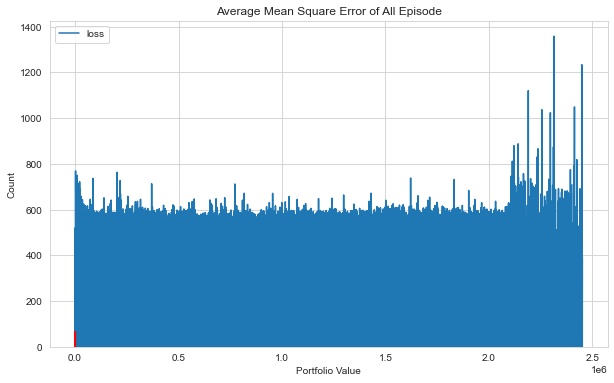

In [10]:
#train


mode = 'train'

portfolio_value = []



for e in tqdm(range(num_episodes)):
    t0 = datetime.now()
    val = play_one_episode(agent, env, mode)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val['portfolio_value'][-1]:.2f}, duration: {dt}")
    portfolio_value.append(val['portfolio_value'][-1]) 


if mode == 'train':
    # save the DQN
    agent.save(f'state_dict/{stock_name}.npz')

    # save the scaler
    with open(f'scaler/{stock_name}.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # plot losses
    loss = agent.model.losses
    losses = pd.DataFrame(loss, columns=['loss'])
    losses.plot(figsize=(10,6))
    plt.title('Average Mean Square Error of All Episode')
    plt.xlabel('Step')
    plt.ylabel('Mean Square Error')

print(f'average reward: {np.mean(portfolio_value):.2f}, min: {np.min(portfolio_value):.2f}, max: {np.max(portfolio_value):.2f}')
sns.histplot(portfolio_value, bins=100, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

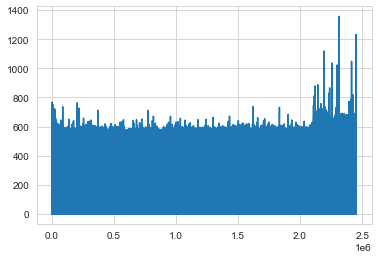

In [11]:
plt.plot(agent.model.losses)

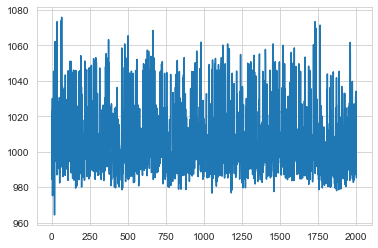

In [12]:
plt.plot(portfolio_value)

episode end value: 985.05, duration: 0:00:00.055018
Sell: 50 times, Buy: 48 times


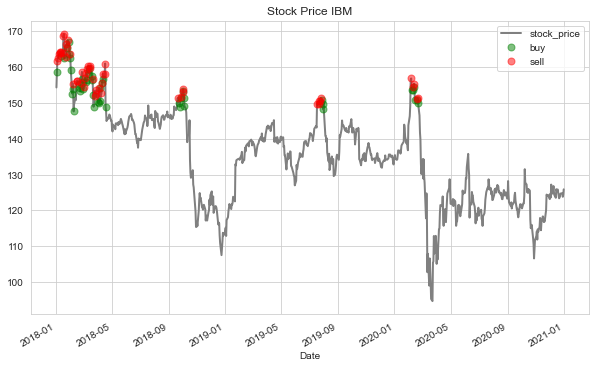

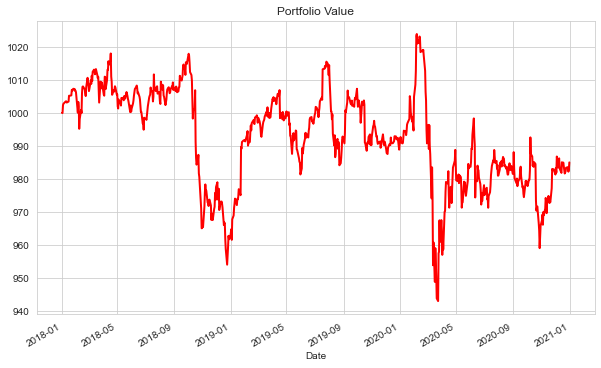

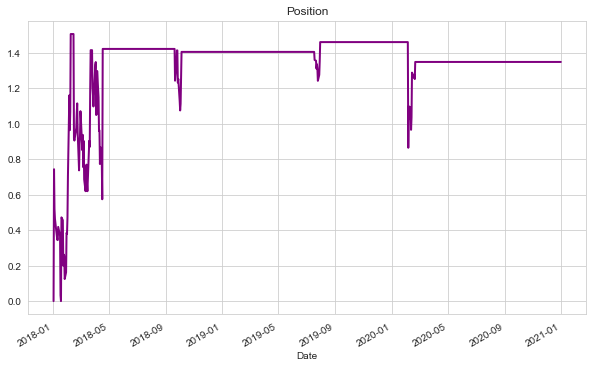

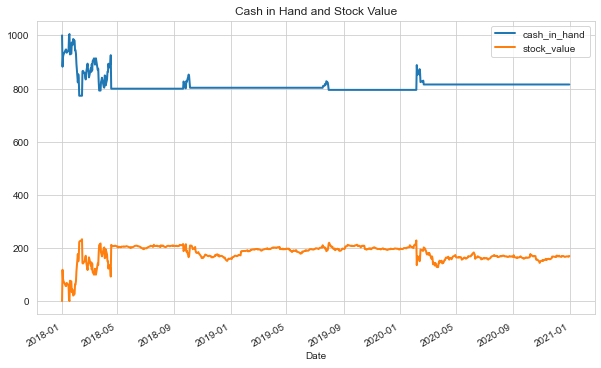

In [13]:
#test

mode = 'test'




with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
env = StockEnv(test_data, capital)
agent.epsilon = 0
agent.load(f'state_dict/{stock_name}.npz')



t0 = datetime.now()
val = play_one_episode(agent, env, mode)
dt = datetime.now() - t0
print(f"episode end value: {val['portfolio_value'][-1]:.2f}, duration: {dt}")

    
print(f"Sell: {env.sell_buy.count('sell')} times, Buy: {env.sell_buy.count('buy')} times")



result = pd.DataFrame(val)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw=2);
result['marker_buy'].plot(style='o', ms=7, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()



result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(10,6), c='purple', lw=2);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(10,6), lw=2);
plt.title('Cash in Hand and Stock Value');
plt.show()

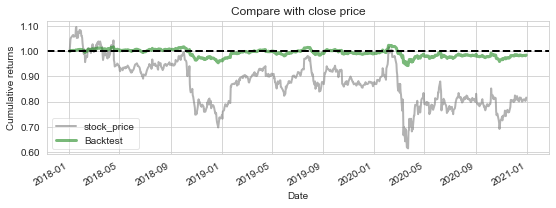

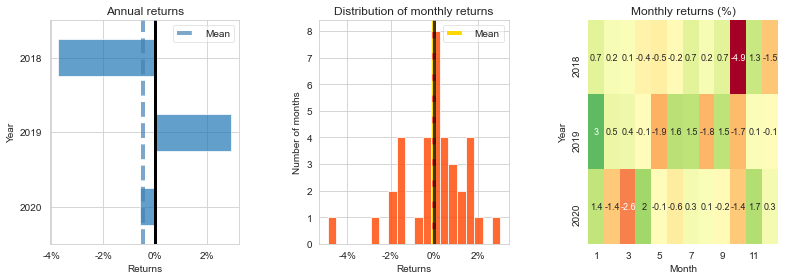

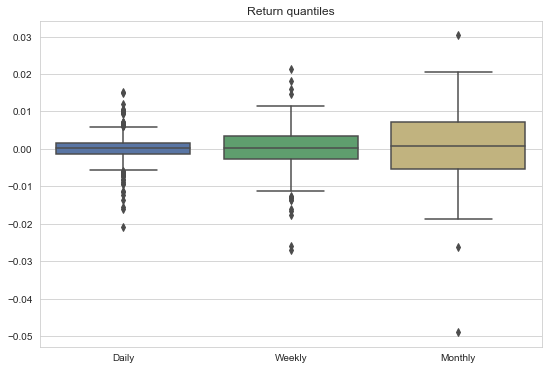

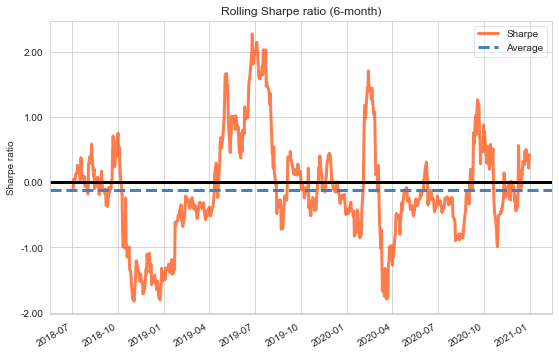

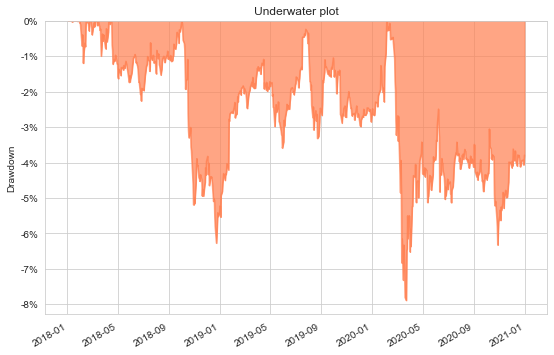

In [14]:
import pyfolio as pf
sns.set_style('whitegrid')

bt_returns = result['portfolio_value'].pct_change()
price = result['stock_price'].pct_change()



plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');
plt.show()

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(12,4)

plt.figure(figsize=(9,6))
pf.plot_return_quantiles(bt_returns);



plt.figure(figsize=(9,6))
pf.plot_rolling_sharpe(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_drawdown_underwater(bt_returns);